# Predicting the fuel consumption (Regression)

I will build a model to predict how much fuel will be consumed for a trip based on the distance to be travelled, the speed at which the vehicle be driven, weather conditions, etc. This can help in deciding whether a refill is required or not prior to the journey by checking the actual fuel left in the vehicle. Also useful for calculating the cost of fuel prior to the trip.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importing the cleaned file from EDA notebook

data=pd.read_csv('data/cleaned_data.csv')
data

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,time
0,28.0,5.0,26,21.5,12,E10,0,0,0,64.62
1,12.0,4.2,30,21.5,13,E10,0,0,0,24.00
2,11.2,5.5,38,21.5,15,E10,0,0,0,17.68
3,12.9,3.9,36,21.5,14,E10,0,0,0,21.50
4,18.5,4.5,46,21.5,15,E10,0,0,0,24.13
...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,SP98,0,0,0,24.62
384,16.1,4.3,38,25.0,31,SP98,1,0,0,25.42
385,16.0,3.8,45,25.0,19,SP98,0,0,0,21.33
386,15.4,4.6,42,25.0,31,SP98,1,0,0,22.00


In [3]:
data.dtypes

distance        float64
consume         float64
speed             int64
temp_inside     float64
temp_outside      int64
gas_type         object
ac                int64
rain              int64
sun               int64
time            float64
dtype: object

### Correlation

C:\Users\jaine\AppData\Local\Temp\ipykernel_9228\2516053288.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix= data.corr()


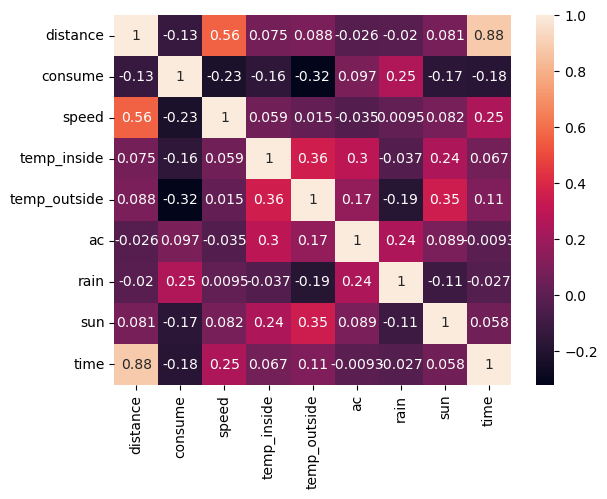

In [4]:
#checking for correlation with each other as well as with the target 'consume'
corr_matrix= data.corr()
sns.heatmap(corr_matrix,annot=True)
plt.show()

No columns are highly correlated with each other or the target 'consume' (>0.95), so no need to drop any columns.

### X,y split

In [5]:
X= data.drop('consume',axis=1)
y=data['consume']

### Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=42)

### Separating categorical and numerical

In [7]:
#numerical
X_train_num=X_train.select_dtypes(np.number)
X_test_num=X_test.select_dtypes(np.number)

In [8]:
#categorical
X_train_cat=X_train.select_dtypes(object)
X_test_cat=X_test.select_dtypes(object)

### Scaling and transforming

In [9]:
#scaling numerical
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler().fit(X_train_num)
X_train_scaled=pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns)

#same transformer to scale test data
X_test_scaled=pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [10]:
# one-hot encoding categorcial
from sklearn.preprocessing import OneHotEncoder

encoder= OneHotEncoder(drop='first').fit(X_train_cat)
X_train_encoded=pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=encoder.get_feature_names_out())

#same encoder for test data
X_test_encoded=pd.DataFrame(encoder.transform(X_test_cat).toarray(),columns=encoder.get_feature_names_out())

### Concatenating transformed numerical and categorical in one dataframe

In [11]:
X_train_trans=pd.concat([X_train_scaled,X_train_encoded],axis=1)
X_test_trans=pd.concat([X_test_scaled,X_test_encoded],axis=1)

### Testing regression models

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_list=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(),RandomForestRegressor()]

In [13]:
def run_model(models, X_tr, y_tr,X_te, y_te):
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")

In [14]:
run_model(model_list,X_train_trans,y_train,X_test_trans,y_test)

LinearRegression: Train -> 0.3352396193207968, Test -> 0.1913183797201271
KNeighborsRegressor: Train -> 0.4780809608370723, Test -> 0.2774608925643792
DecisionTreeRegressor: Train -> 0.9995763862324677, Test -> -0.14483745618246147
RandomForestRegressor: Train -> 0.9458244531297768, Test -> 0.4812235853370128


Random forest has the best results so we willl try to optimise it.

### Hyper parameter optimization of Random Forest

In [16]:
#find an optimum max_depth for random forest

max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = RandomForestRegressor(max_depth=depth, random_state=0)
    model.fit(X_train_trans, y_train)
    test.append(model.score(X_test_trans,y_test))
    train.append(model.score(X_train_trans,y_train))

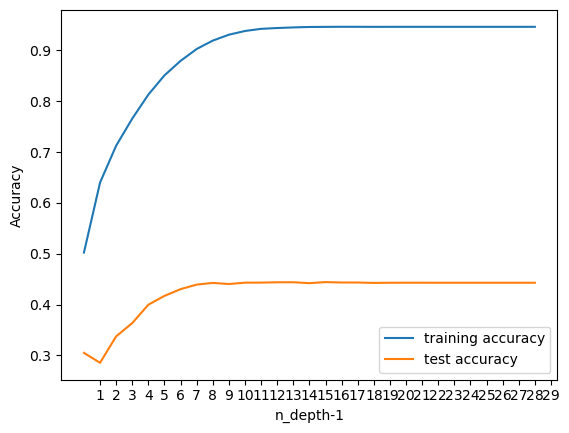

In [17]:
#need to remember our range starts from 1 so max_depth from plot should be n_depth+1
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.xticks(max_depth)
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

#from the plot max_depth=10

#### Using RandomizedSearchCV

In [23]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [24]:
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_trans, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [26]:
#best parameters from random search
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [29]:
# making predictions using the model with best parameters

best_model=rf_random.best_estimator_

pred=best_model.predict(X_test_trans)

#### Model Evaluation

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 0.42781556205588206
Mean Squared Error: 0.37292341182910005
R-squared: 0.5889772669507987


Before optimisation: Test -> 0.4812235853370128 \
After optimisation: Test -> 0.5889772669507987

Improvement of ~10% with hyperparameter optimisation

In [36]:
pred_df= pd.DataFrame({'Actual':y_test,'Predicted':pred}).reset_index(drop=True)
pred_df

,Actual,Predicted
0,5.6,6.068790
1,5.1,5.197953
2,6.1,4.983522
3,4.6,4.691185
4,4.3,4.130324
...,...,...
73,3.9,4.677451
74,4.9,4.796350
75,4.7,4.792630
76,4.7,4.832654
